# Assignment 4 Solution

This is my solution for CS 533 Assignment 4.

The purpose of assignment is to use simulations to explore the behavior of linear models under various conditions.

**Note:** I am going to reuse the same variable names frequently.  This means that running the notebook out of order is a recipe to get very confused.

## Setup

As usual, we have some setup to do.  We're going to import our commonly-used modules:

In [1]:
from collections import namedtuple
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

Since this assignment makes heavy use of randomized simulation, we want to set up seeded random number generator for reproducibility. I am going to use Seedbank for this.

In [2]:
import seedbank
seedbank.initialize(20211022)
rng = seedbank.numpy_rng()

I don't expect you to do this, but I'm also going to get a progress bar (this requires ipywidgets installed):

In [3]:
from tqdm.auto import tqdm

We don't actually need much more setup, because this assignment doesn't load any data.

### Support Function: Iterations

We can use the standard Python `range` function for our loops.  However, as we get to more complicated iterations, it's going to be quite useful to have progress bars.  We also run most of our simulations for 1000 iterations.  I'm therefore going to define a helper function that yields simulation iterations, just like `range`, but provides a progress bar, and gives us one place to configure the default iteration count:

In [4]:
def sim_iters(count=1000):
    return tqdm(range(count), leave=False)

## Warmup: Correlation

The first part of our exploration is to compute correlations of simulated data, before we get to actually computing linear models.

Uncorrelated data should have a correlation coefficient of (approximately) 0.  Two independent sequences from a standard normal should be uncorrelated - let's see what happens when we do that:

In [5]:
xs = pd.Series(rng.standard_normal(100))
ys = pd.Series(rng.standard_normal(100))
xs.corr(ys)

-0.30846389450728195

That correlation coefficient is rather large, actually.  But that can happen randomly on occasion; for a better explanation, let's repeat this.

### Repeated Correlation

What does the *sampling distribution* of this correlation coefficient look like it if we run it 1000 times?  Thinking ahead, I'm going to write a function to compute a correlation from independent samples:

In [6]:
def corr_of_indep(n=100):
    xs = pd.Series(rng.standard_normal(n))
    ys = pd.Series(rng.standard_normal(n))
    return xs.corr(ys)

And call it 1000 times, and get the mean and variance as a (mean, variance) tuple:

In [7]:
corrs = pd.Series([corr_of_indep() for i in sim_iters()])
np.mean(corrs), np.var(corrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0034727650278805512, 0.009640583703845053)

The mean correlation is quite small, and the variance is also relatively narrow. What does the distribution look like?

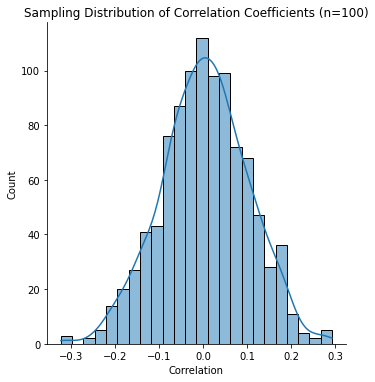

In [8]:
sns.displot(x=corrs, kde=True)
plt.xlabel('Correlation')
plt.title('Sampling Distribution of Correlation Coefficients (n=100)')
plt.show()

It looks like our initial correlation of -0.3 is unlucky. Our distribution looks approximately centered around 0 (uncorrelated), which is what we would expect — it's possible to accidentally draw positively (or negatively) correlated variables, but generally we're going to se small, and often 0, correlation.

### Increased Sample Size

The next step is to increase our *sample size* (`n`) from 100 to 1000, and try this again:

In [9]:
corrs = np.array([corr_of_indep(1000) for i in sim_iters()])
np.mean(corrs), np.var(corrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0004829566263429417, 0.0010079105752090135)

Our mean is closer to zero, and our variance is smaller (0.001 is much smaller than ~0.01).  Let's see the distribution:

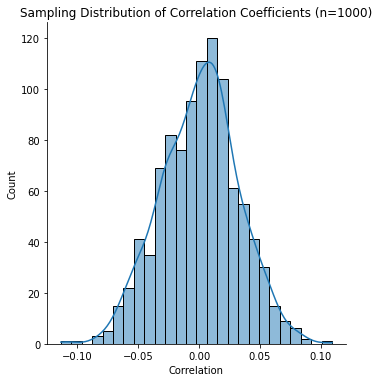

In [10]:
sns.displot(x=corrs, kde=True)
plt.xlabel('Correlation')
plt.title('Sampling Distribution of Correlation Coefficients (n=1000)')
plt.show()

We're centered around 0-ish again, but with our distribution is over a much narrower width of correlations values: $|r|>0.1$ is very unlikely.  This distribution may look skewed; this is due to the random chance.  You can verify this by running many more simulation iterations (e.g. 100,000 instead of 1000) to get a more accurate approximation of the sampling distribution.

### Correlated Variables

Those variables were uncorrelated, so we should expect to see a correlation coefficient of 0.  What happens when we have correlated variables?  Let's explore a simple correlated variables case, looking $\operatorname{Cor}(X, Z)$ where:

$$\begin{align}
X & \sim \mathrm{Normal}(0, 1) \\
Y & \sim \mathrm{Normal}(0, 1) \\
Z & = X + Y
\end{align}$$

We can derive $\operatorname{Cor}(X, Z) = \frac{\mathrm{Cov}(X, Z)}{\sigma_X\sigma_Z} = 1 / \sqrt{2} = 0.707$, so our coefficients should be approximately 0.707.  More precisely:

In [11]:
pop_r = 1 / np.sqrt(2)
pop_r

0.7071067811865475

Let's write a function to compute these:

In [12]:
def corr_of_sum(n=100):
    xs = pd.Series(rng.standard_normal(n))
    ys = pd.Series(rng.standard_normal(n))
    zs = xs + ys
    return xs.corr(zs)

And try it out quick:

In [13]:
corr_of_sum()

0.6535953500151018

A little low, but let's try repeating it 1000 times:

In [14]:
corrs = pd.Series([corr_of_sum() for i in sim_iters()])
np.mean(corrs), np.var(corrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.7044336341866134, 0.002630560854125453)

That mean is pretty close to what we would expect!  Let's plot that distribution, along with a vertical line at the theoretical value:

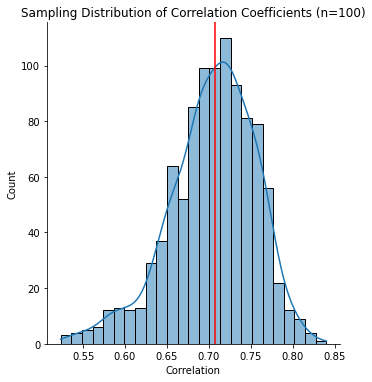

In [15]:
sns.displot(x=corrs, kde=True)
plt.axvline(pop_r, color='red')
plt.xlabel('Correlation')
plt.title('Sampling Distribution of Correlation Coefficients (n=100)')
plt.show()

The theoretical value is right in the center of mass of the distribution.

Let's see what happens when we use 1000 samples per iteration:

In [16]:
corrs = pd.Series([corr_of_sum(1000) for i in sim_iters()])
np.mean(corrs), np.var(corrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.7064437694468347, 0.00022563961634946954)

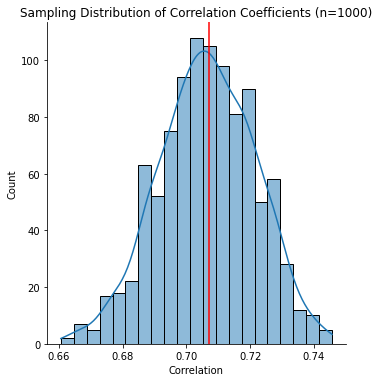

In [17]:
sns.displot(x=corrs, kde=True)
plt.axvline(pop_r, color='red')
plt.xlabel('Correlation')
plt.title('Sampling Distribution of Correlation Coefficients (n=1000)')
plt.show()

Both numerically and visually, we can see that the mean correlation stays around the theoretical value, but the variance is decreasing. We usually expect sampling variances to decrease as the sample size increases! Let's bring the sample size up to 10,000 and see what happens:

In [18]:
corrs = pd.Series([corr_of_sum(10000) for i in sim_iters()])
np.mean(corrs), np.var(corrs)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.706989678454396, 2.5048621458900675e-05)

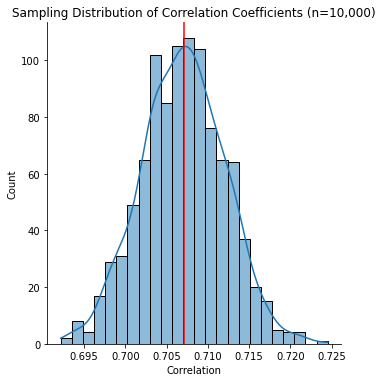

In [19]:
sns.displot(x=corrs, kde=True)
plt.axvline(pop_r, color='red')
plt.xlabel('Correlation')
plt.title('Sampling Distribution of Correlation Coefficients (n=10,000)')
plt.show()

Even smaller variance in our correlations. Each of these correlation distributions has roughly the same shape, but its variance changes - with larger sample sizes, there is less variation in correlations from one run to another from the same underlying population parameters.

## Linear Regression

Now that we've seen how to set up simulations, we're going tos start simulating linear regressions.

### Running a Regression

Our first run will be to fit a regression to one set of linear data:

In [20]:
xs = rng.standard_normal(1000)
errs = rng.standard_normal(1000)
ys = 0 + 1 * xs + errs
data = pd.DataFrame({
    'X': xs,
    'Y': ys
})
lm = smf.ols('Y ~ X', data)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     953.1
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          1.88e-147
Time:                        12:32:38   Log-Likelihood:                -1418.3
No. Observations:                1000   AIC:                             2841.
Df Residuals:                     998   BIC:                             2850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0292      0.032     -0.924      0.356      -0.091       0.033
X              0.9589      0.031     30.872      0.000       0.898       1.020
==============================================================================
Omnibus:                        0.652   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.722   Jarque-Bera (JB):                0.679
Skew:                           0.062   Prob(JB):                        0.712
Kurtosis:                       2.966   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This line is statistically significant ($p$ all quite small, except for the intercept, but our data data generation process has an intercept of 0, so that's what we should see).  Our linear model also learned approximately our original parameters - an intercept of 0 and slope of 1.  $R^2 = 0.488$, indicating it explains about half the variance; this makes sense, because $x$ has a variance of 1, which is directly propagated to $y$ (since the slope is 1), and the residuals contribute an equal variance since they are also drawn from a normal with unit variance (1).  Half the variacne is therefore explained by the model.

We can also plot it on the data:

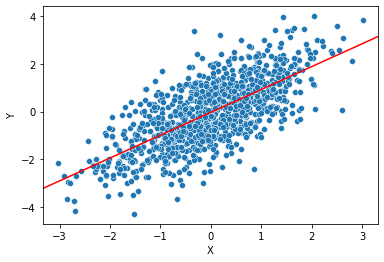

In [21]:
sns.scatterplot(x='X', y='Y', data=data)
plt.axline((0, fit.params['Intercept']), slope=fit.params['X'], color='red')
plt.show()

And we want to look at our diagnostic plots - are the residuals normal?

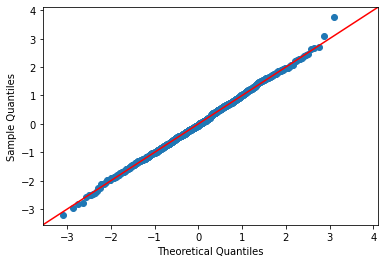

In [22]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

That looks pretty normal; the mild deviations at the tails are not a problem. Let's look at residuals vs. fitted:

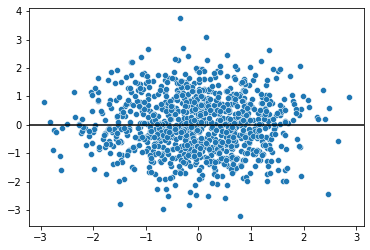

In [23]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

The values aren't as high in the higher and lower values, but that's because we don't have as many values there: $x$ is normally-distributed, so $\hat{y}$ is normally distributed; when there are fewer values out at -2.5 and 2.5, there are fewer opportunities to draw an extreme residual, even with constant variance.  From this plot, we don't have evidence of heteroskedasticity.

**This is what we expect:** we drew our residuals $\epsilon \sim \mathrm{Normal}(0, 1)$ - we know they are i.i.d. normal, and we see that in our assumption check plots.

### Repeated Regression

But that's just one run.  What happens if we run a lot of regressions? How much variance do our regression parameters have?  What are their distributions?

We're going to write a function to compute those.

In [24]:
def simulate_std_lm(icept=0, slope=1):
    xs = rng.standard_normal(1000)
    errs = rng.standard_normal(1000)
    ys = icept + slope * xs + errs
    data = pd.DataFrame({
        'X': xs,
        'Y': ys
    })
    lm = smf.ols('Y ~ X', data)
    fit = lm.fit()
    return {
        'Intercept': fit.params['Intercept'],
        'Slope': fit.params['X'],
        'RSquared': fit.rsquared
    }

Now I'll use that to make a data frame:

In [25]:
df = pd.DataFrame.from_records(
    simulate_std_lm() for i in sim_iters()
)
df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,Intercept,Slope,RSquared
0,-0.049101,1.022036,0.493988
1,-0.021181,0.974359,0.456270
2,0.029607,1.011484,0.518630
3,-0.030124,0.928705,0.460269
4,0.036500,0.982734,0.490722


Let's look at the means and variances of each of these:

In [26]:
df.agg(['mean', 'var'])

,Intercept,Slope,RSquared
mean,0.000620,0.999595,0.499514
var,0.001044,0.001011,0.000492


The mean parameters - intercept and slope - match our data generation process, and $R^2$ is also nicely centered around 0.5, as it should be (from the argument above).

Let's plot the distributions:

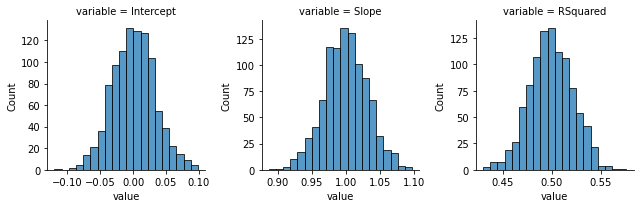

In [27]:
grid = sns.FacetGrid(col='variable', data=df.melt(), sharex=False, sharey=False)
grid.map(sns.histplot, 'value', bins=20)
plt.show()

We can see these roughly symmetrically distributed around their true values, which is good!  If we increased our sample size per iteration, we would see the variances decrease.

### Changing the Parameters

Finally, we're going to look at $y = 1 + 4x + \epsilon$, with $x$ and $\epsilon$ drawn as before.

In [28]:
xs = rng.standard_normal(1000)
errs = rng.standard_normal(1000)
ys = 1 + 4 * xs + errs
data = pd.DataFrame({
    'X': xs,
    'Y': ys
})
lm = smf.ols('Y ~ X', data)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.797e+04
Date:                Mon, 25 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:32:43   Log-Likelihood:                -1358.8
No. Observations:                1000   AIC:                             2722.
Df Residuals:                     998   BIC:                             2731.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0348      0.030     34.716      0.000       0.976       1.093
X              3.9763      0.030    134.049      0.000       3.918       4.035
==============================================================================
Omnibus:                        1.377   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.429
Skew:                           0.058   Prob(JB):                        0.489
Kurtosis:                       2.856   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our model has recovered the parameters pretty well (intercept and slope are correct).  The $R^2$ is much higher now (0.940).  This is because $\hat{y}$ now has higher variance: $x \sim \mathrm{Normal}(0, 1)$ has variance of 1, but $4x$ has a variance of 16 ($\sigma_{4x} = 4 \sigma_x$, since the normal distribution is in the scale-location family).  The residuals, however, still only have a variance of 1.  Therefore the model is explaining a much greater fraction of the total variance in $y$.

You can also get to this answer from an argument about the relationship of the slope, the correlation, and the variances, and observing that changing the slope will have a significant impact on $r$ and therefore $R^2$ (since $R^2$ is the square of the Pearson correlation for single regression).

Now let's look at the model & assumption plots:

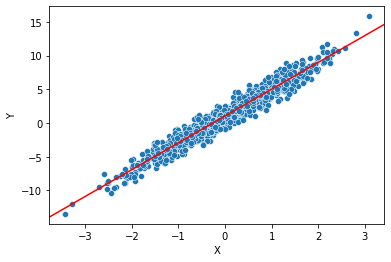

In [29]:
sns.scatterplot(x='X', y='Y', data=data)
plt.axline((0, fit.params['Intercept']), slope=fit.params['X'], color='red')
plt.show()

#### Assumption Checks

And we want to look at our diagnostic plots - are the residuals normal?

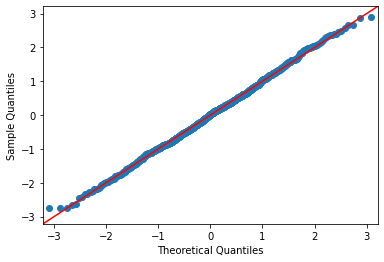

In [30]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

That looks pretty normal. Let's look at residuals vs. fitted:

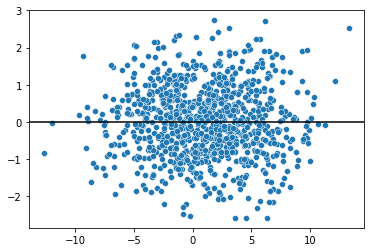

In [31]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

We know from the data generation process that our assumptions hold, and we don't see any violation of that in the assumption check plots.

#### Repeated Parameter Change

And finally, let's repeat this model:

In [32]:
df = pd.DataFrame.from_records(
    simulate_std_lm(1, 4) for i in sim_iters()
)
df.agg(['mean', 'var'])

  0%|          | 0/1000 [00:00<?, ?it/s]

,Intercept,Slope,RSquared
mean,1.000286,4.001878,0.941053
var,0.000979,0.001003,0.000012


The means are around where we expect - distributions?

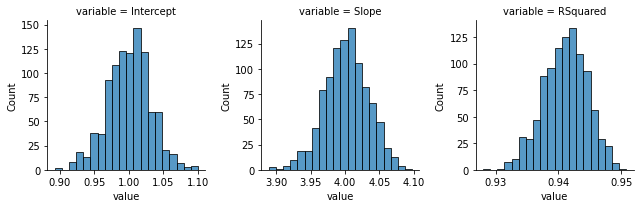

In [33]:
grid = sns.FacetGrid(col='variable', data=df.melt(), sharex=False, sharey=False)
grid.map(sns.histplot, 'value', bins=20)
plt.show()

The sampling distribution is approximately normal and centered around the true mean (1 and 4 for intercept and slope - I will allow you to derive $R^2$).

## Nonlinear Data

Our next model is to look at data with a nonlinear relationship - specifically, an exponential function of $x$: $y = 10 + 5 e^x + \epsilon$.  Let's draw our data points:

In [34]:
xs = rng.standard_normal(1000)
errs = rng.standard_normal(1000) * 5
ys = 10 + 5 * np.exp(xs) + errs
data = pd.DataFrame({
    'X': xs,
    'Y': ys
})
lm = smf.ols('Y ~ X', data)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     984.4
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          6.63e-151
Time:                        12:32:48   Log-Likelihood:                -3479.5
No. Observations:                1000   AIC:                             6963.
Df Residuals:                     998   BIC:                             6973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.2516      0.249     73.424      0.000      17.764      18.739
X              7.9051      0.252     31.375      0.000       7.411       8.400
==============================================================================
Omnibus:                      944.786   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96183.723
Skew:                           3.955   Prob(JB):                         0.00
Kurtosis:                      50.390   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our original DGP had an intercept of 10, but now we see 18. Our slope was also 5, and now we see 7.7 - let's look at this model and data:

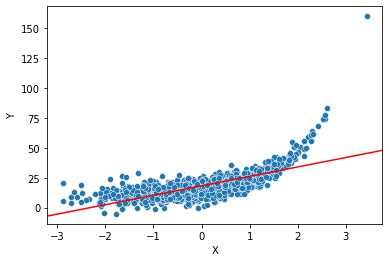

In [35]:
sns.scatterplot(x='X', y='Y', data=data)
plt.axline((0, fit.params['Intercept']), slope=fit.params['X'], color='red')
plt.show()

The data is definitely not a line, but we knew that already. When you try to fit a line to data, you get weird stuff!

We have violated the **linearity assumption** (which we know from the DGP).

### Assumption Checks

Let's see what shows up in our diagnostic plots.

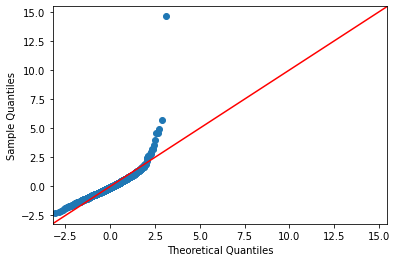

In [36]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

Whatever normal is, this isn't it.  Let's look at residuals vs. fitted:

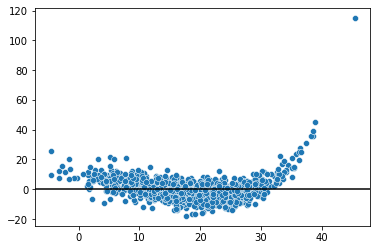

In [37]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

The residuals are very clearly not i.i.d. normal.

Note that the noise in our actual DGP is i.i.d. normal: $\epsilon \sim \mathrm{Normal}(0, 5)$.  However, the residuals of trying to fit a line to that data are *not*.

An exercise for you: what happens if you fit a linear model to predict $\operatorname{log} y$ with $x$?

### Change the Formula

Now we're going to repeat the exercise with a different, but still non-linear, formula:

In [38]:
xs = rng.standard_normal(1000)
errs = rng.standard_normal(1000) * 5
ys = -2 + 3 * (xs ** 3) + errs
data = pd.DataFrame({
    'X': xs,
    'Y': ys
})
lm = smf.ols('Y ~ X', data)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     893.5
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          1.01e-140
Time:                        12:32:48   Log-Likelihood:                -3769.0
No. Observations:                1000   AIC:                             7542.
Df Residuals:                     998   BIC:                             7552.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9486      0.332     -5.869      0.000      -2.600      -1.297
X              9.7085      0.325     29.892      0.000       9.071      10.346
==============================================================================
Omnibus:                     1239.034   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           499053.488
Skew:                          -5.842   Prob(JB):                         0.00
Kurtosis:                     111.815   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our original DGP had an intercept of -2, and we're seeing about that; however, the coefficient is 9.7 instead of 3. Let's look at this model and data:

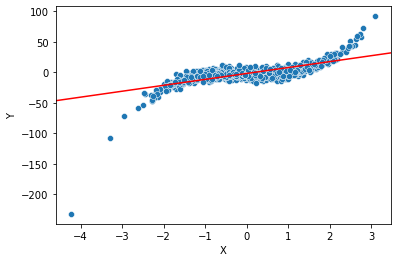

In [39]:
sns.scatterplot(x='X', y='Y', data=data)
plt.axline((0, fit.params['Intercept']), slope=fit.params['X'], color='red')
plt.show()

That data is not linear. It's plausibly linear in the middle, but we didn't fit that line.


Let's see what shows up in our diagnostic plots.

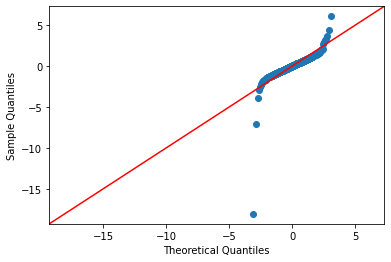

In [40]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

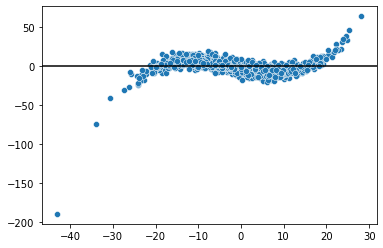

In [41]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

Again, our residuals are very much not i.i.d. normal.

## Non-Normal Covariates

We're now going to fit a linear model, but $x$ won't be normal any more.  $\epsilon$ still will be.

In [42]:
xs = rng.gamma(2, 1, 1000)
errs = rng.standard_normal(1000)
ys = 10 + 0.3 * xs + errs
data = pd.DataFrame({
    'X': xs,
    'Y': ys
})

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>]], dtype=object)

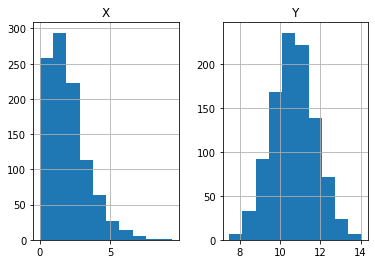

In [43]:
data.hist()

$X$ has serious right skew going on. $Y$ is closer to symmetric; this is because it's a combination of the skewed $X$ and symmetrically distributed $\epsilon$, so it will be skewed but not as strongly.

Now let's fit the model:

In [44]:
lm = smf.ols('Y ~ X', data)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     176.5
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           3.36e-37
Time:                        12:32:49   Log-Likelihood:                -1411.7
No. Observations:                1000   AIC:                             2827.
Df Residuals:                     998   BIC:                             2837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0703      0.055    181.592      0.000       9.962      10.179
X              0.3011      0.023     13.284      0.000       0.257       0.346
==============================================================================
Omnibus:                        0.096   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.953   Jarque-Bera (JB):                0.155
Skew:                           0.015   Prob(JB):                        0.925
Kurtosis:                       2.947   Cond. No.                         4.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our model paramters are about right (10 and 0.3); $R^2$ is pretty low, though - only explains 17.5% of the variance.  Let's start looking at the model & diagnostics:

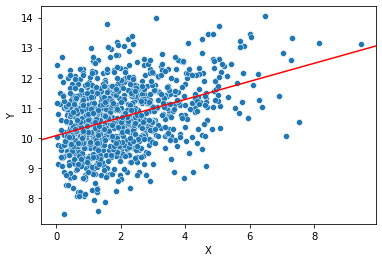

In [45]:
sns.scatterplot(x='X', y='Y', data=data)
plt.axline((0, fit.params['Intercept']), slope=fit.params['X'], color='red')
plt.show()

That might be a line.

### Assumption Checks

Let's see what shows up in our diagnostic plots.

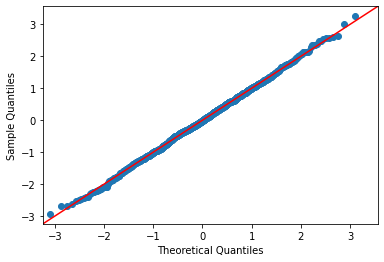

In [46]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

Residuals show no evidence of non-normality.

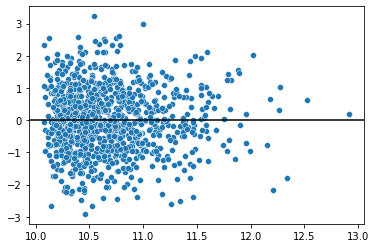

In [47]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

The data are so concentrated on the left, that there are not many points on the right. We don't have evidence of heteroskedasticity - a few points won't necessarily draw extreme values.

### Conclusions

We know from the DGP that the assumptions *do* hold: the relationship is linear, and the residuals are i.i.d. normal.  We have just changed the distribution of $x$ (and therefore $y$).  This linear model is fine; there's just a lot of noise in the data, so we can't explain much.  Let's look at our residual and $Y$ variance:

In [48]:
np.var(data['Y'])

1.1599344857755018

In [49]:
np.var(errs)

0.9856529019434349

The residuals have a lot of intrinsic variance (compared to the total outcome variance), so $R^2$ will be relatively low.

## Multiple Regression

Now, we're going to do a regression with two independent variables, and the model $y = 1 + 0.5x_1 + 3x_2 + \epsilon$, with $\epsilon$ again a standard normal.

Let's draw $X_1$ and $X_2$, and make a data frame:

In [50]:
xs = rng.multivariate_normal([10, -2], [[2, 0], [0, 5]], 1000)
xdf = pd.DataFrame(xs, columns=['X1', 'X2'])

Draw our errors and compute $Y$:

In [51]:
errs = rng.standard_normal(1000)
xdf['Y'] = 1 + 0.5 * xdf['X1'] + 3 * xdf['X2'] + errs

And fit our model:

In [52]:
lm = smf.ols('Y ~ X1 + X2', data=xdf)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.398e+04
Date:                Mon, 25 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:32:49   Log-Likelihood:                -1420.1
No. Observations:                1000   AIC:                             2846.
Df Residuals:                     997   BIC:                             2861.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7155      0.233      3.066      0.002       0.258       1.173
X1             0.5283      0.023     23.055      0.000       0.483       0.573
X2             3.0039      0.014    216.896      0.000       2.977       3.031
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                1.142
Skew:                          -0.044   Prob(JB):                        0.565
Kurtosis:                       3.140   Cond. No.                         76.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The slopes and intercept are approximately what we expect from the DGP specified above - a little different, but that's within the bounds of random noise.  Let's look at our assumption checks:

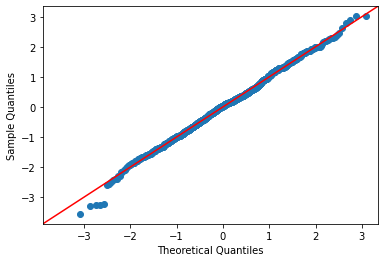

In [53]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

Residuals show no evidence of non-normality.

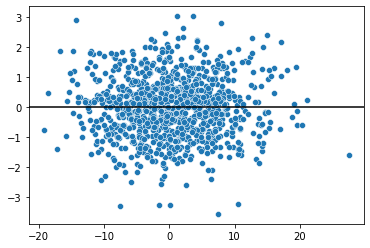

In [54]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

Things generally look fine here.  We also know from the DGP that our assumptions hold - the data is truly linear, residuals are i.i.d. normal, and we don't have any correlations between predictors to foul things up.

## Correlated Predictors

Finally, we're going to look at what happens with multiple regression when we have *correlated* predictors.  The `multivariate_normal` allows us to specify the covariacne between two variables, so we're going to do that to draw $X_1$ and $X_2$ with covariance of 0.85:

In [55]:
xs = rng.multivariate_normal([1, 3], [[1, 0.85], [0.85, 1]], 1000)
xdf = pd.DataFrame(xs, columns=['X1', 'X2'])

Draw some errors and compute $Y$ such that $y = 3 + 2x_1 + 3x_2 + \epsilon$, with $\epsilon \sim \mathrm{Normal}(0, 2)$:

In [56]:
errs = rng.standard_normal(1000) * 2
xdf['Y'] = 3 + 2 * xdf['X1'] + 3 * xdf['X2'] + errs

This model also meets the assumptions — linearity, i.i.d normal residuals — but we have these pesky correlated predictors.

Let's fit our model:

In [57]:
lm = smf.ols('Y ~ X1 + X2', data=xdf)
fit = lm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     3251.
Date:                Mon, 25 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:32:50   Log-Likelihood:                -2072.1
No. Observations:                1000   AIC:                             4150.
Df Residuals:                     997   BIC:                             4165.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8288      0.258     10.964      0.000       2.323       3.335
X1             1.9391      0.118     16.449      0.000       1.708       2.170
X2             3.0787      0.115     26.731      0.000       2.853       3.305
==============================================================================
Omnibus:                        3.241   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.183
Skew:                          -0.097   Prob(JB):                        0.204
Kurtosis:                       3.196   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The slopes and intercept are approximately what we expect from the DGP specified above, again.  Let's look at our residual checks:

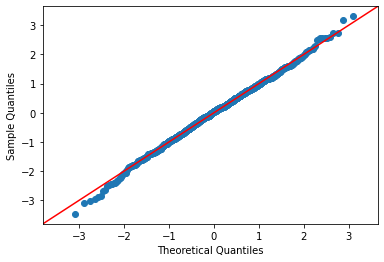

In [58]:
sm.qqplot(fit.resid, fit=True, line='45')
plt.show()

Residuals show no evidence of non-normality.

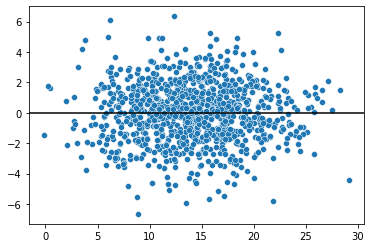

In [59]:
plt.axhline(0, color='black')
sns.scatterplot(x=fit.fittedvalues, y=fit.resid)
plt.show()

Things generally look fine here.

### Repeating the Experiment

Now let's repeat the experiment, and look at the variance of these fits.

We're going to make a function to parameterize this model over the covariance:

In [60]:
def simulate_corr_lm(cov=0.85, n=1000):
    xs = rng.multivariate_normal([1, 3], [[1, cov], [cov, 1]], n)
    xdf = pd.DataFrame(xs, columns=['X1', 'X2'])
    errs = rng.standard_normal(n) * 2
    xdf['Y'] = 3 + 2 * xdf['X1'] + 3 * xdf['X2'] + errs
    lm = smf.ols('Y ~ X1 + X2', data=xdf)
    fit = lm.fit()
    return fit.params

And run the simulation:

In [61]:
corr_df = pd.DataFrame.from_records(
    simulate_corr_lm() for i in sim_iters(100)
)
corr_df.agg(['mean', 'var'])

  0%|          | 0/100 [00:00<?, ?it/s]

,Intercept,X1,X2
mean,3.018384,2.006311,2.991479
var,0.053950,0.011405,0.010361


Our means are about right.  The variances in estimates are higher than what we saw in the earlier repeated LM plots, but that on its own isn't enough to really draw conclusions right now.

Let's plot these estimates:

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'X1'}>],
       [<AxesSubplot:title={'center':'X2'}>, <AxesSubplot:>]],
      dtype=object)

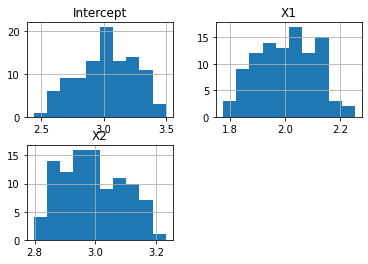

In [62]:
corr_df.hist()

### Sweeping the Covariance

There's one final thing we want to do.  The variances were perhaps high, but we need some context.  What does it look like without any correlation?

In [63]:
corr_df = pd.DataFrame.from_records(
    simulate_corr_lm(0) for i in sim_iters(100)
)
corr_df.agg(['mean', 'var'])

  0%|          | 0/100 [00:00<?, ?it/s]

,Intercept,X1,X2
mean,3.005170,1.995523,2.998691
var,0.043722,0.003636,0.004238


Those variances, particularly on the slopes are notably lower.  Let's look at *variance of estimate* as a function of *covariance of data*, by repeating our experiment:

In [64]:
COV_LIST = [0, 0.5, 0.85, 0.9, 0.99, 0.999]
corr_vars = []
for cov in tqdm(COV_LIST, leave=False):
    corr_df = pd.DataFrame.from_records(
        simulate_corr_lm(cov) for i in sim_iters(100)
    )
    cv = corr_df.var()
    cv['cov'] = cov
    corr_vars.append(cv)
corr_vars = pd.DataFrame.from_records(corr_vars)
corr_vars

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,Intercept,X1,X2,cov
0,0.049493,0.005131,0.004150,0.000
1,0.036211,0.004774,0.004292,0.500
2,0.077752,0.016382,0.015779,0.850
3,0.102003,0.022838,0.022190,0.900
4,0.697271,0.170486,0.167707,0.990
5,9.149614,2.247535,2.276573,0.999


Now let's plot these variables:

In [65]:
cv_tall = corr_vars.melt(id_vars='cov', value_name='Variance')
cv_tall.head()

,cov,variable,Variance
0,0.00,Intercept,0.049493
1,0.50,Intercept,0.036211
2,0.85,Intercept,0.077752
3,0.90,Intercept,0.102003
4,0.99,Intercept,0.697271


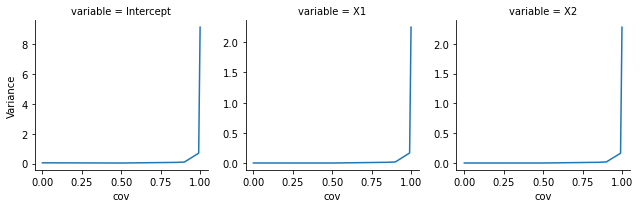

In [66]:
grid = sns.FacetGrid(col='variable', data=cv_tall, sharey=False)
grid.map(sns.lineplot, 'cov', 'Variance')

We can see that, as the covariance (correlation) between our predictors increases, the *variance* in our regression parameter estimates increases as well.

**This is the single biggest thing I wanted you to see in this assignment.**

$X_1$ and $X_2$ are *multicollinear*.  They have a shared component $X_*$, and the linear model doesn't know whether to put the coefficient that would go on that component in $X_1$ or $X_2$.  It can even learn to put an overly strong coefficient on $X_1$ and a *negative* coefficient on $X_2$ to compensate — in the presence of strongly correlated predictors, you can see sign inversions when you add or remove a predictor.

The outcome of this is that if you have highly correlated predictors, you **cannot** trust a linear model, even if it might pass assumption checks - the model is just too unstable.

## Reflection

This is where you would put your reflection.